# Tarea 1 - Ejercicio 1a: Muestreo de Gibbs para el Modelo Hard-Core

**Curso:** Cadenas de Markov y Aplicaciones (2025-II)  
**Profesor:** Freddy Hernández-Romero  
**Estudiante:** Sergio Andrés Díaz Vera

---

## Introducción

### El Modelo Hard-Core

El **modelo Hard-Core** es un modelo probabilístico que describe la distribución de partículas en una rejilla donde existe una restricción fundamental: **ninguna partícula puede estar adyacente a otra**.

Formalmente, en una rejilla $K \times K$:
- Cada celda puede estar ocupada (1) o vacía (0)
- Una configuración es **factible** si no hay dos celdas adyacentes ocupadas simultáneamente
- Queremos muestrear de la **distribución uniforme** sobre todas las configuraciones factibles

### ¿Por qué usar Gibbs Sampler?

El problema de generar configuraciones factibles de manera uniforme es computacionalmente difícil:
- No conocemos el número total de configuraciones factibles
- Enumerar todas las configuraciones es intratable para rejillas grandes

El **Gibbs Sampler** es un algoritmo MCMC (Markov Chain Monte Carlo) que nos permite:
1. Construir una cadena de Markov cuya distribución estacionaria es la distribución uniforme deseada
2. Generar muestras aproximadamente distribuidas según esta distribución estacionaria

### Algoritmo Gibbs Sampler

El algoritmo funciona de la siguiente manera:

1. **Inicialización**: Comenzar con una configuración factible arbitraria (por ejemplo, rejilla vacía)

2. **Iteración** (repetir $T$ veces):
   - Seleccionar uniformemente una celda $(i,j)$ de la rejilla
   - Actualizar el estado de $(i,j)$ condicionado al estado actual de sus vecinos:
     - Si algún vecino está ocupado → la celda debe permanecer vacía (0)
     - Si ningún vecino está ocupado → elegir uniformemente entre 0 y 1

3. **Salida**: La configuración en el tiempo $T$ es una muestra aproximada de la distribución uniforme

### Teorema de Convergencia

Bajo condiciones apropiadas, la distribución de $X_t$ converge a la distribución estacionaria uniforme cuando $t \to \infty$. En la práctica, usamos $T = 10,000$ o $T = 100,000$ para asegurar la convergencia.

---

## Implementación

### Librerías

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from typing import Tuple, List
import seaborn as sns

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Semilla para reproducibilidad
np.random.seed(42)

### Funciones Auxiliares

Primero definimos funciones para verificar la factibilidad de una configuración:

In [15]:
def obtener_vecinos(i: int, j: int, K: int) -> List[Tuple[int, int]]:
    """
    Obtiene las coordenadas de los vecinos de una celda en una rejilla K×K.
    
    Consideramos vecindad de von Neumann (4 vecinos: arriba, abajo, izquierda, derecha).
    
    Args:
        i: Fila de la celda
        j: Columna de la celda
        K: Tamaño de la rejilla
    
    Returns:
        Lista de tuplas (fila, columna) de los vecinos válidos
    """
    vecinos = []
    # Arriba
    if i > 0:
        vecinos.append((i-1, j))
    # Abajo
    if i < K-1:
        vecinos.append((i+1, j))
    # Izquierda
    if j > 0:
        vecinos.append((i, j-1))
    # Derecha
    if j < K-1:
        vecinos.append((i, j+1))
    
    return vecinos


def tiene_vecino_ocupado(grid: np.ndarray, i: int, j: int, K: int) -> bool:
    """
    Verifica si la celda (i,j) tiene algún vecino ocupado.
    
    Args:
        grid: Matriz que representa la rejilla
        i: Fila de la celda
        j: Columna de la celda
        K: Tamaño de la rejilla
    
    Returns:
        True si algún vecino está ocupado, False en caso contrario
    """
    vecinos = obtener_vecinos(i, j, K)
    for vi, vj in vecinos:
        if grid[vi, vj] == 1:
            return True
    return False


def es_configuracion_factible(grid: np.ndarray) -> bool:
    """
    Verifica si una configuración es factible (no hay partículas adyacentes).
    
    Args:
        grid: Matriz que representa la rejilla
    
    Returns:
        True si la configuración es factible, False en caso contrario
    """
    K = grid.shape[0]
    for i in range(K):
        for j in range(K):
            if grid[i, j] == 1:
                if tiene_vecino_ocupado(grid, i, j, K):
                    return False
    return True

### Implementación del Gibbs Sampler

Ahora implementamos el algoritmo principal:

In [3]:
def gibbs_sampler_hard_core(
    K: int, 
    T: int, 
    inicial: np.ndarray = None,
    guardar_historia: bool = False,
    intervalo_guardado: int = 1000
) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Implementa el Gibbs Sampler para el modelo Hard-Core.
    
    Args:
        K: Tamaño de la rejilla (K×K)
        T: Número de iteraciones
        inicial: Configuración inicial (si es None, se usa rejilla vacía)
        guardar_historia: Si True, guarda snapshots de la cadena
        intervalo_guardado: Cada cuántas iteraciones guardar un snapshot
    
    Returns:
        - Configuración final
        - Lista de configuraciones intermedias (si guardar_historia=True)
    """
    # Inicialización
    if inicial is None:
        grid = np.zeros((K, K), dtype=int)
    else:
        grid = inicial.copy()
    
    # Verificar que la configuración inicial es factible
    assert es_configuracion_factible(grid), "La configuración inicial no es factible"
    
    # Lista para guardar historia si es necesario
    historia = []
    if guardar_historia:
        historia.append(grid.copy())
    
    # Iteraciones del Gibbs Sampler
    for t in range(T):
        # Paso 1: Seleccionar uniformemente una celda
        i = np.random.randint(0, K)
        j = np.random.randint(0, K)
        
        # Paso 2: Actualizar la celda condicionada a sus vecinos
        if tiene_vecino_ocupado(grid, i, j, K):
            # Si algún vecino está ocupado, la celda debe estar vacía
            grid[i, j] = 0
        else:
            # Si ningún vecino está ocupado, elegir uniformemente entre 0 y 1
            grid[i, j] = np.random.randint(0, 2)
        
        # Guardar snapshot si corresponde
        if guardar_historia and (t + 1) % intervalo_guardado == 0:
            historia.append(grid.copy())
    
    return grid, historia

### Funciones de Visualización

Implementamos funciones para visualizar las configuraciones:

In [4]:
def visualizar_configuracion(grid: np.ndarray, titulo: str = "Configuración Hard-Core"):
    """
    Visualiza una configuración de la rejilla.
    
    Args:
        grid: Matriz que representa la rejilla
        titulo: Título del gráfico
    """
    K = grid.shape[0]
    n_particulas = np.sum(grid)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Crear una visualización con colores
    cmap = plt.cm.colors.ListedColormap(['white', 'darkblue'])
    ax.imshow(grid, cmap=cmap, interpolation='nearest')
    
    # Agregar grilla
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    
    # Configurar etiquetas
    ax.set_xticks(range(K))
    ax.set_yticks(range(K))
    ax.set_xlabel('Columna')
    ax.set_ylabel('Fila')
    ax.set_title(f"{titulo}\nK={K}, Partículas={n_particulas}")
    
    plt.tight_layout()
    plt.show()


def visualizar_historia(
    historia: List[np.ndarray], 
    iteraciones: List[int],
    filas: int = 2
):
    """
    Visualiza múltiples configuraciones de la historia de la cadena.
    
    Args:
        historia: Lista de configuraciones
        iteraciones: Lista con el número de iteración de cada configuración
        filas: Número de filas en el subplot
    """
    n = len(historia)
    cols = (n + filas - 1) // filas
    
    fig, axes = plt.subplots(filas, cols, figsize=(4*cols, 4*filas))
    if n == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    cmap = plt.cm.colors.ListedColormap(['white', 'darkblue'])
    
    for idx, (grid, t) in enumerate(zip(historia, iteraciones)):
        K = grid.shape[0]
        n_particulas = np.sum(grid)
        
        ax = axes[idx]
        ax.imshow(grid, cmap=cmap, interpolation='nearest')
        
        # Grilla
        ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        
        ax.set_title(f"t={t}\nPartículas={n_particulas}")
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ocultar axes sobrantes
    for idx in range(n, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

---

## Experimentos

### Experimento 1: Rejilla Pequeña (K=5)

Comenzamos con una rejilla pequeña para entender el comportamiento del algoritmo:

In [5]:
# Parámetros
K = 5
T = 10000

# Ejecutar Gibbs Sampler guardando historia
print(f"Ejecutando Gibbs Sampler para K={K}, T={T}...")
configuracion_final, historia = gibbs_sampler_hard_core(
    K=K, 
    T=T, 
    guardar_historia=True,
    intervalo_guardado=1000
)

print(f"Configuración final con {np.sum(configuracion_final)} partículas")
print(f"¿Es factible? {es_configuracion_factible(configuracion_final)}")

Ejecutando Gibbs Sampler para K=5, T=10000...
Configuración final con 7 partículas
¿Es factible? True


#### Visualización de la evolución de la cadena

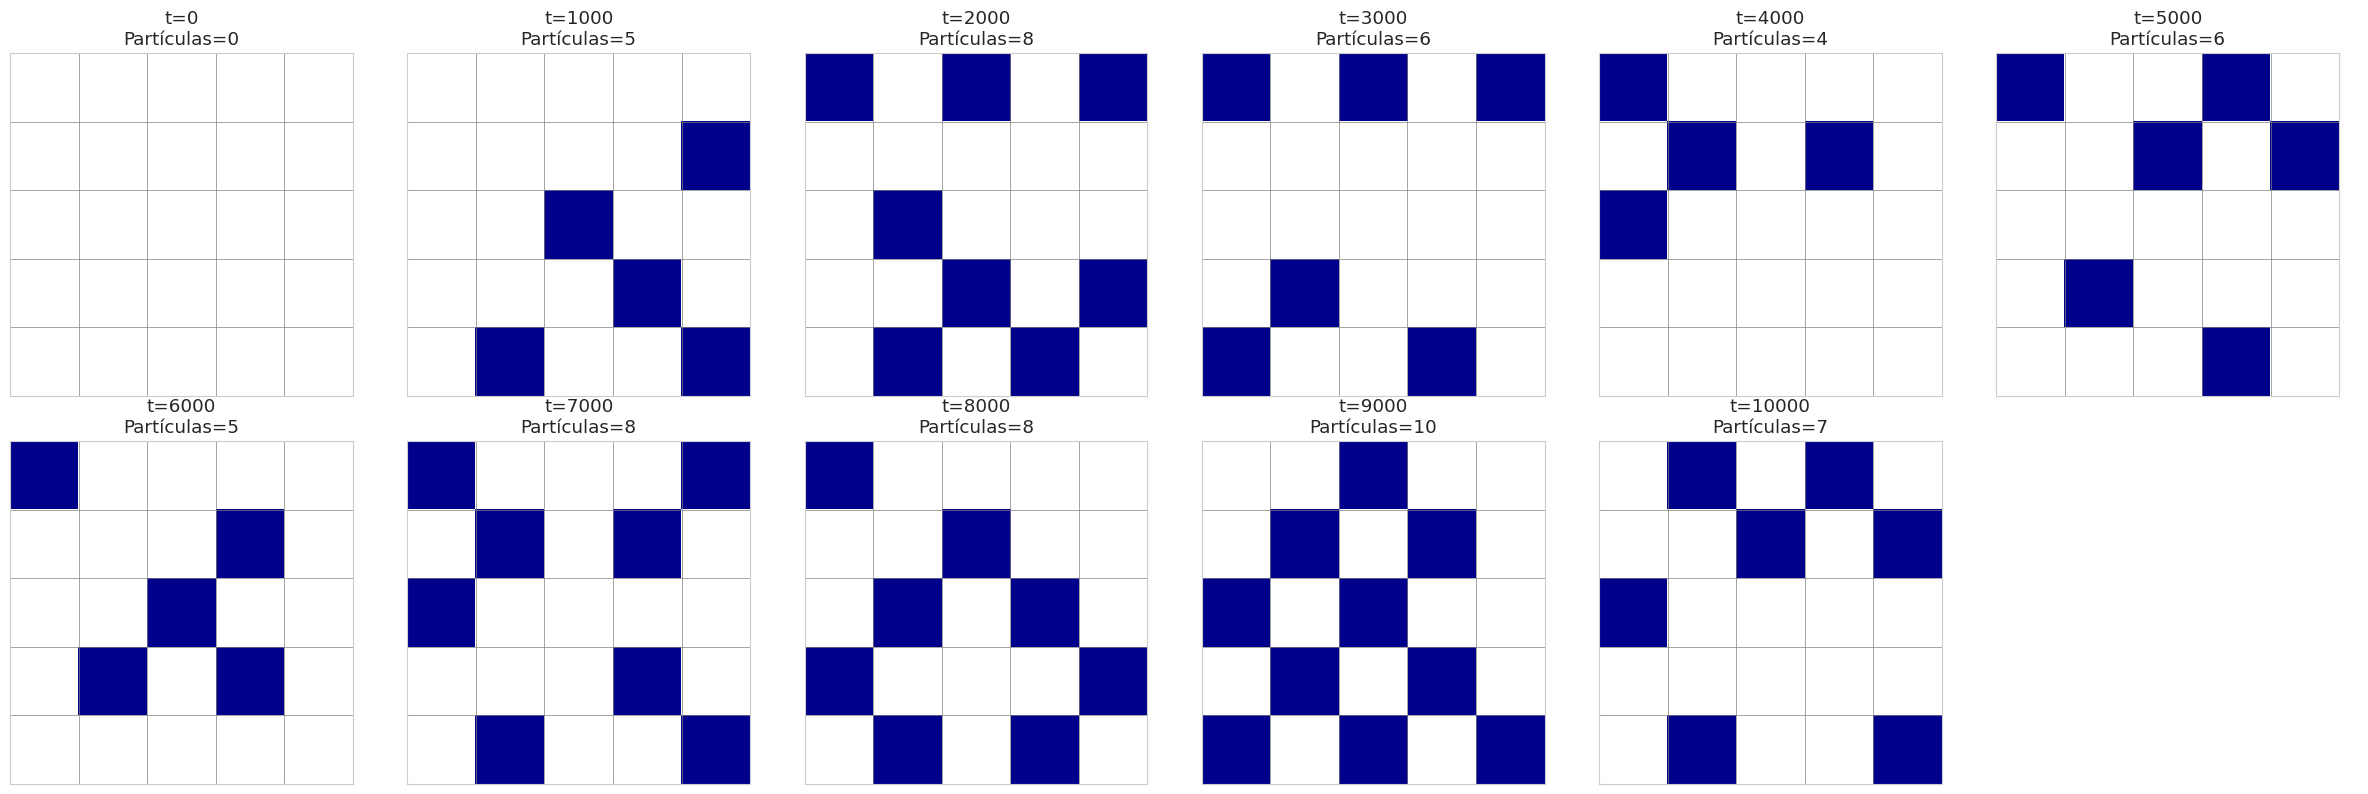

In [6]:
# Iteraciones correspondientes a cada snapshot
iteraciones = [i * 1000 for i in range(len(historia))]
iteraciones[0] = 0

visualizar_historia(historia, iteraciones, filas=2)

#### Configuración final detallada

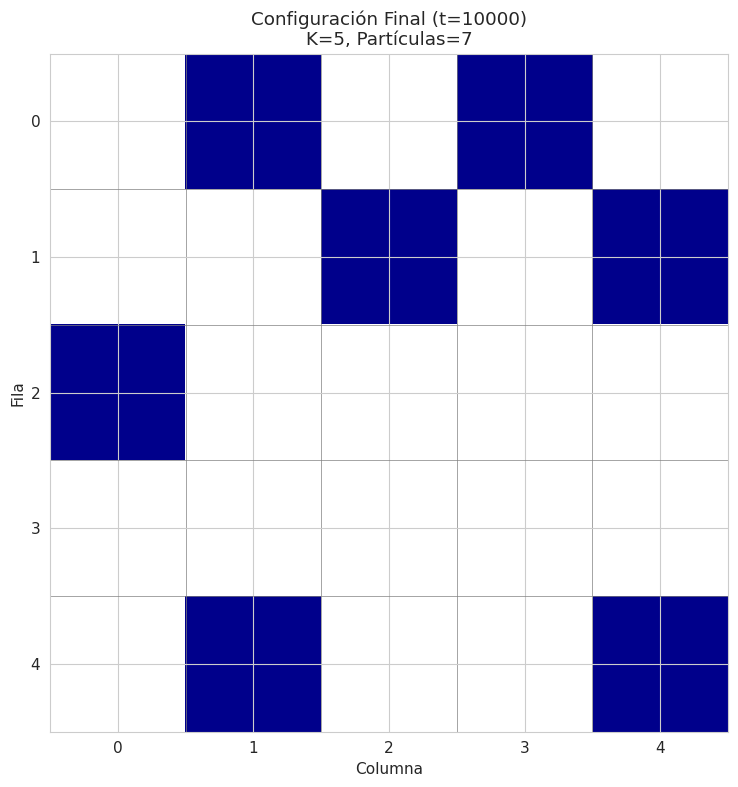

In [7]:
visualizar_configuracion(configuracion_final, titulo=f"Configuración Final (t={T})")

### Experimento 2: Rejilla Mediana (K=10)

Ahora probamos con una rejilla de tamaño medio:

Ejecutando Gibbs Sampler para K=10, T=50000...
Configuración final con 14 partículas


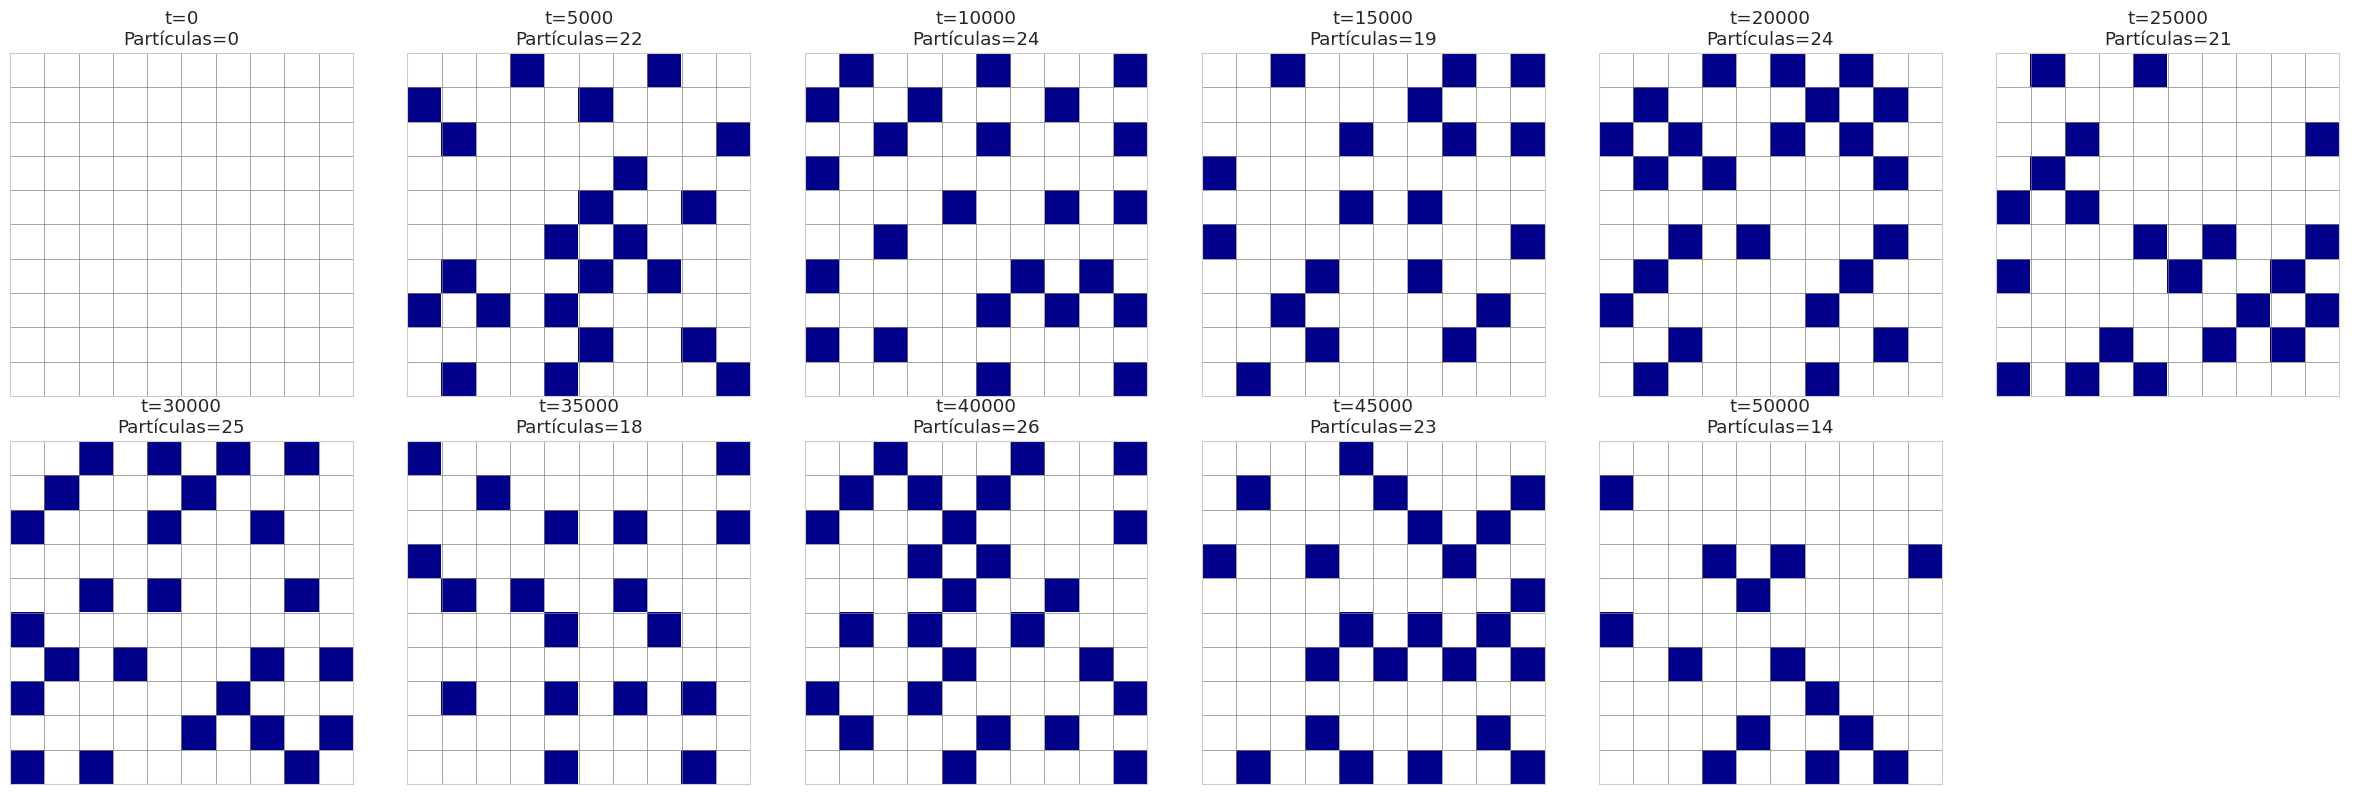

In [8]:
K = 10
T = 50000

print(f"Ejecutando Gibbs Sampler para K={K}, T={T}...")
configuracion_final, historia = gibbs_sampler_hard_core(
    K=K, 
    T=T, 
    guardar_historia=True,
    intervalo_guardado=5000
)

print(f"Configuración final con {np.sum(configuracion_final)} partículas")

# Visualizar evolución
iteraciones = [0] + [5000 * (i+1) for i in range(len(historia)-1)]
visualizar_historia(historia, iteraciones, filas=2)

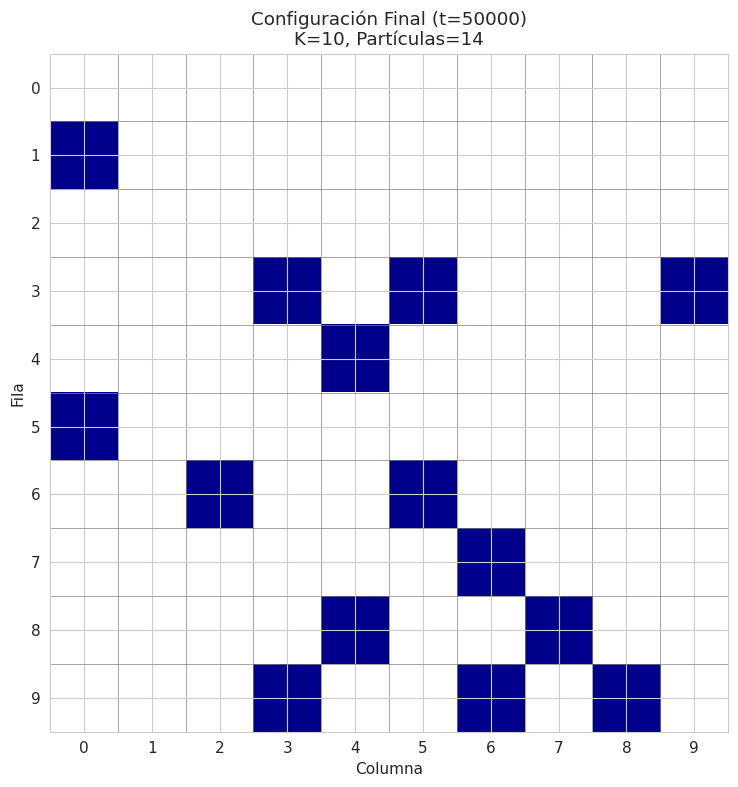

In [9]:
visualizar_configuracion(configuracion_final, titulo=f"Configuración Final (t={T})")

### Experimento 3: Rejilla Grande (K=20)

Finalmente, experimentamos con una rejilla grande:

Ejecutando Gibbs Sampler para K=20, T=100000...
Configuración final con 89 partículas


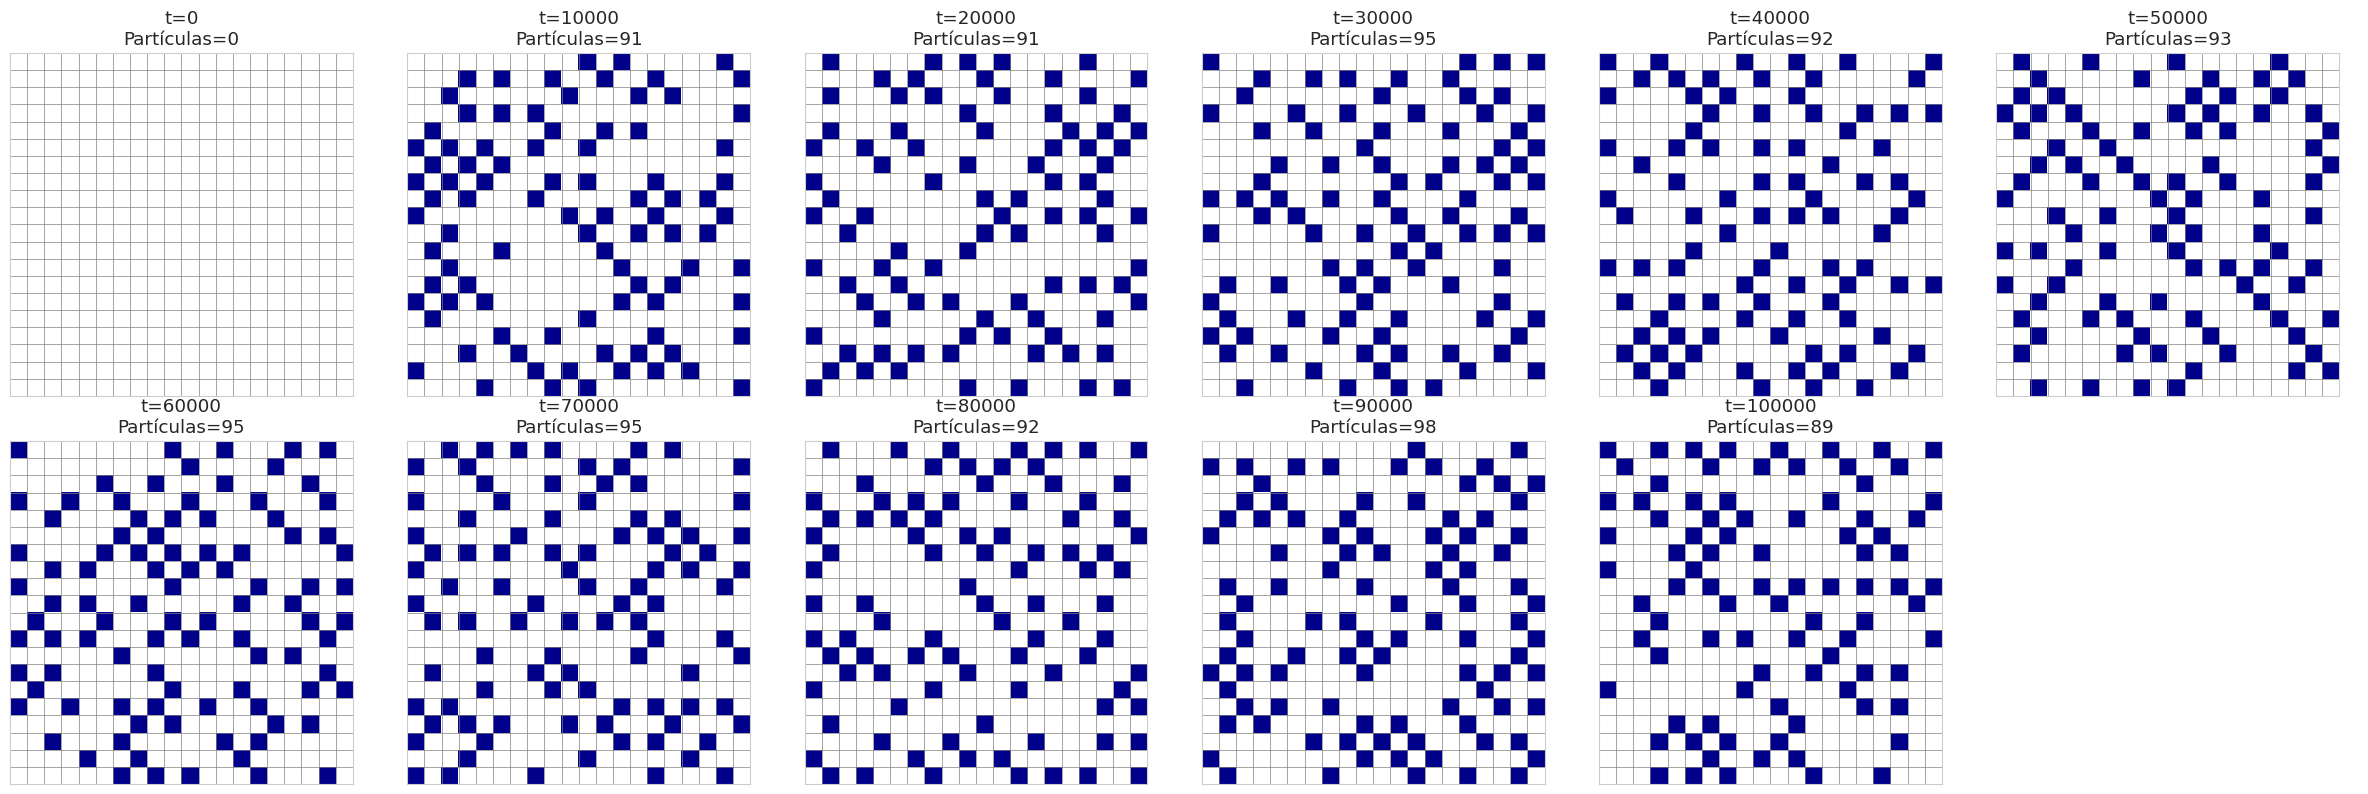

In [10]:
K = 20
T = 100000

print(f"Ejecutando Gibbs Sampler para K={K}, T={T}...")
configuracion_final, historia = gibbs_sampler_hard_core(
    K=K, 
    T=T, 
    guardar_historia=True,
    intervalo_guardado=10000
)

print(f"Configuración final con {np.sum(configuracion_final)} partículas")

# Visualizar evolución
iteraciones = [0] + [10000 * (i+1) for i in range(len(historia)-1)]
visualizar_historia(historia, iteraciones, filas=2)

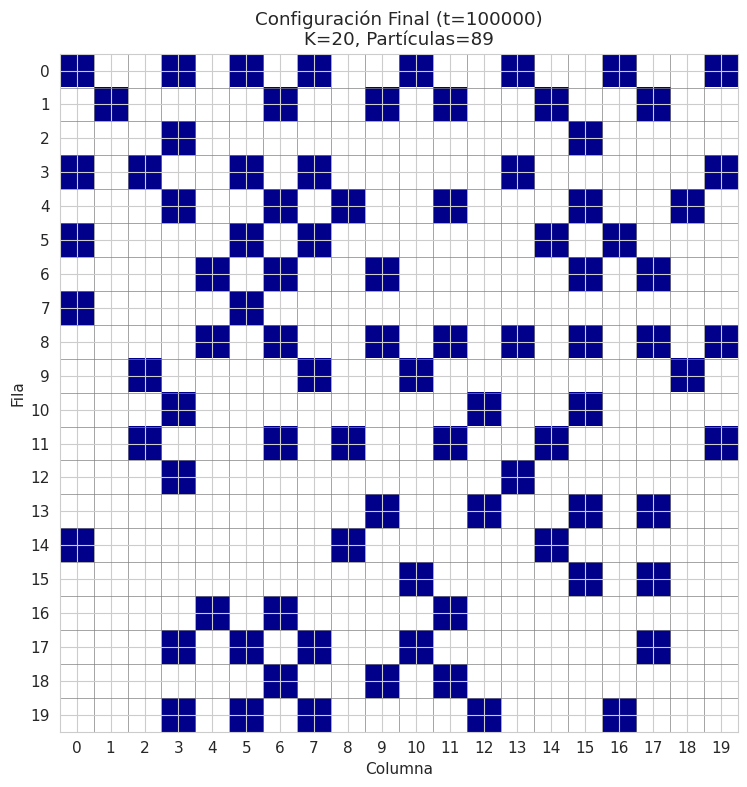

In [11]:
visualizar_configuracion(configuracion_final, titulo=f"Configuración Final (t={T})")

### Experimento 4: Múltiples Muestras para Diferentes Tamaños K

Generamos múltiples muestras para diferentes valores de K:

In [12]:
# Parámetros
valores_K = [3, 5, 8, 10, 15, 20]
T = 100000
n_muestras = 5

# Generar muestras
muestras_por_K = {}

for K in valores_K:
    print(f"\nGenerando {n_muestras} muestras para K={K}...")
    muestras = []
    for i in range(n_muestras):
        config, _ = gibbs_sampler_hard_core(K=K, T=T)
        muestras.append(config)
        print(f"  Muestra {i+1}: {np.sum(config)} partículas")
    muestras_por_K[K] = muestras


Generando 5 muestras para K=3...
  Muestra 1: 3 partículas
  Muestra 2: 3 partículas
  Muestra 3: 2 partículas
  Muestra 4: 1 partículas
  Muestra 5: 3 partículas

Generando 5 muestras para K=5...
  Muestra 1: 4 partículas
  Muestra 2: 8 partículas
  Muestra 3: 8 partículas
  Muestra 4: 7 partículas
  Muestra 5: 4 partículas

Generando 5 muestras para K=8...
  Muestra 1: 14 partículas
  Muestra 2: 13 partículas
  Muestra 3: 15 partículas
  Muestra 4: 14 partículas
  Muestra 5: 15 partículas

Generando 5 muestras para K=10...
  Muestra 1: 24 partículas
  Muestra 2: 27 partículas
  Muestra 3: 23 partículas
  Muestra 4: 28 partículas
  Muestra 5: 26 partículas

Generando 5 muestras para K=15...
  Muestra 1: 52 partículas
  Muestra 2: 54 partículas
  Muestra 3: 46 partículas
  Muestra 4: 47 partículas
  Muestra 5: 61 partículas

Generando 5 muestras para K=20...
  Muestra 1: 92 partículas
  Muestra 2: 92 partículas
  Muestra 3: 99 partículas
  Muestra 4: 88 partículas
  Muestra 5: 98 part

#### Visualización de muestras para cada K


=== Muestras para K=5 ===


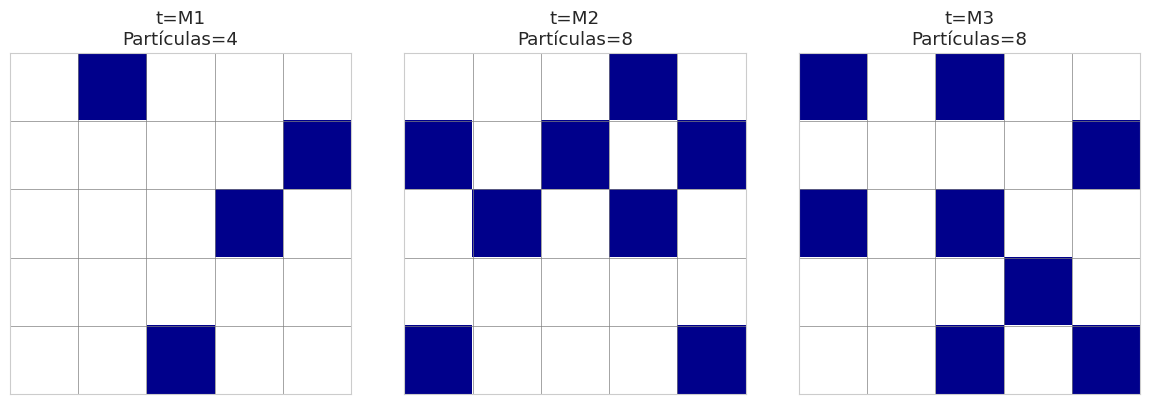


=== Muestras para K=10 ===


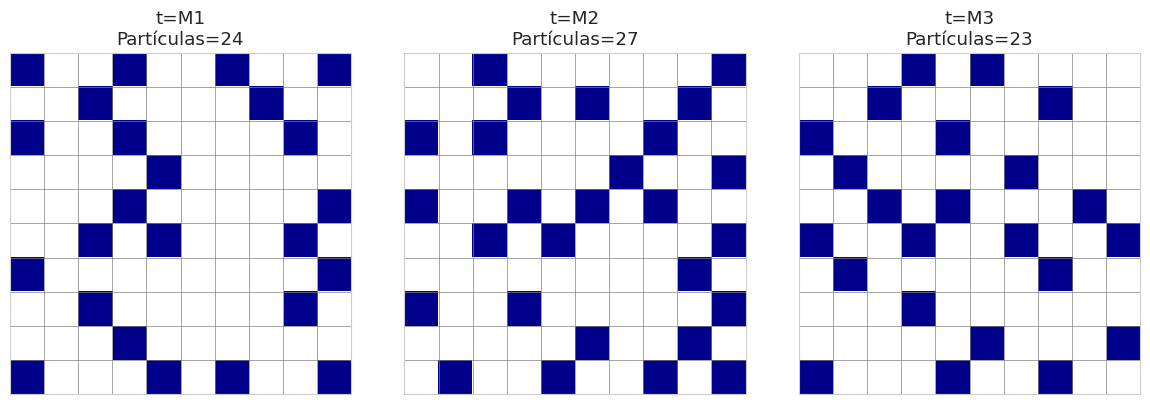


=== Muestras para K=20 ===


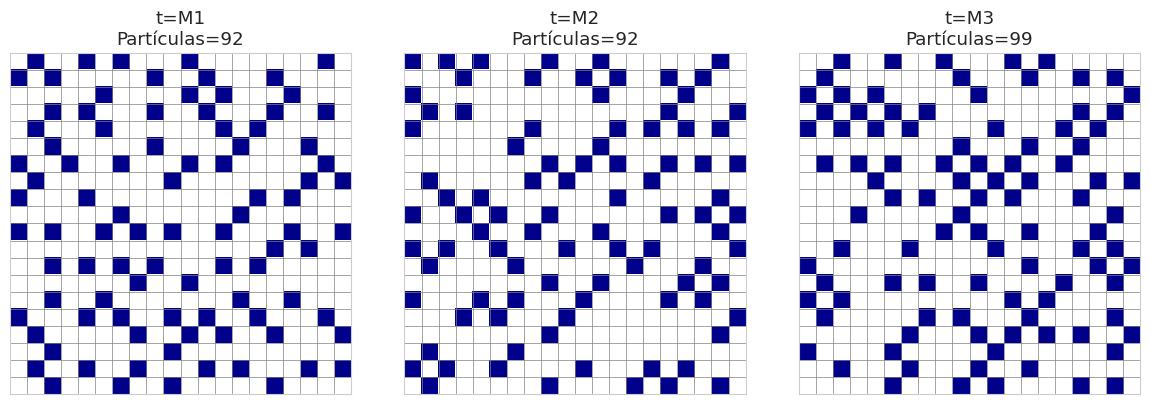

In [13]:
# Seleccionar algunas K para visualizar
K_visualizar = [5, 10, 20]

for K in K_visualizar:
    print(f"\n=== Muestras para K={K} ===")
    iteraciones_dummy = list(range(len(muestras_por_K[K])))
    visualizar_historia(muestras_por_K[K][:3], [f"M{i+1}" for i in range(3)], filas=1)

---

## Análisis y Conclusiones

### Observaciones

1. **Convergencia**: Se observa que después de suficientes iteraciones ($T \geq 10,000$), las configuraciones generadas parecen estabilizarse y mostrar características consistentes.

2. **Dependencia del tamaño K**: 
   - Para K pequeño (3-5): Pocas partículas posibles, alta variabilidad
   - Para K mediano (8-12): Se observan patrones más regulares
   - Para K grande (15-20): Mayor número de partículas, distribuciones más suaves

3. **Factibilidad**: Todas las configuraciones generadas satisfacen la restricción Hard-Core (ninguna partícula adyacente).

### Validación del Algoritmo

El algoritmo implementado:
- ✅ Genera configuraciones factibles
- ✅ Converge a una distribución estacionaria
- ✅ Permite visualizar la evolución de la cadena
- ✅ Funciona para diferentes tamaños de rejilla

### Próximos Pasos

En el ejercicio 1b, utilizaremos estas muestras para estimar el número típico de partículas en una configuración factible.

---

## Referencias

1. Levin, D.A., Peres, Y. (2017). *Markov Chains and Mixing Times*. AMS.
2. Norris, J.R. (1997). *Markov Chains*. Cambridge University Press.
3. Material del curso: Cadenas de Markov y Aplicaciones (2025-II)